In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [2]:
import os
from transformers import BertTokenizer, BertModel


os.environ['TRANSFORMERS_CACHE'] = '/Users/baga_nuhkadiev/.cache/huggingface'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # Get the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state
    # Pool the embeddings (use mean pooling for simplicity)
    pooled_embeddings = torch.mean(embeddings, dim=1)
    return pooled_embeddings.detach().numpy()


# headlines = data['Text'].values
# embeddings = [get_bert_embeddings(headline) for headline in headlines]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [3]:
import math

# import all data
df = pd.read_csv('upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)
training_data_len

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)


(1592, 1) (397, 1)


In [4]:
bert_embeddings = np.load('bert_embeddings.npy')
bert_embeddings.shape

(1989, 1, 768)

In [5]:
bert_train = bert_embeddings[:training_data_len]
bert_test = bert_embeddings[training_data_len:]
print(bert_train.shape, bert_test.shape)

(1592, 1, 768) (397, 1, 768)


In [6]:
# Selecting Open Price values
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test


[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [8]:
bert_train[0:60].shape

(60, 1, 768)

In [9]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_train_emb, X_train, y_train = [], [], []
# asd = []

for i in range(len(scaled_train) - sequence_length):
    X_train_emb.append(bert_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
    X_train.append(scaled_train[i:i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_emb = np.array(X_train_emb)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()
X_train_emb = torch.tensor(X_train_emb, dtype=torch.float32).float().squeeze()


X_train.shape, X_train_emb.shape, y_train.shape


(torch.Size([1542, 50, 1]),
 torch.Size([1542, 50, 768]),
 torch.Size([1542, 50, 1]))

In [10]:
X_train = torch.cat((X_train, X_train_emb), axis=2)

In [11]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
X_test_emb = []

for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
    X_test_emb.append(bert_test[i:i+sequence_length])

X_test, X_test_emb, y_test = np.array(X_test), np.array(X_test_emb), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test_emb = torch.tensor(X_test_emb, dtype=torch.float32).squeeze()
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, X_test_emb.shape, y_test.shape

(torch.Size([367, 30, 1]),
 torch.Size([367, 30, 768]),
 torch.Size([367, 30, 1]))

In [12]:
X_test = torch.cat((X_test, X_test_emb), axis=2)

In [23]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units
	# num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, p): # defines forward pass of the neural network
        out, _ = self.lstm(p)
        # last_out_bert = out_e[:, -1, :]
        # last_out_price = out_p[:, -1, :]
        # print(last_out_bert.shape, last_out_price.shape)
        # out = torch.cat((last_out_bert, last_out_price), dim=1)

        # print(out_e.shape, out_p.shape)
        # combined = torch.cat((out_p, out_e), dim=2)  # Shape: (16, 50, 128)

        # Flatten the tensor
        # batch_size, sequence_length, combined_hidden_size = combined.size()
        # flattened = combined.view(batch_size, -1)  # Shape: (16, 6400)


        # combined = torch.cat((prices, news), dim=2)  # Shape: (16, 50, 128)
        # print(out.shape)
        out = self.linear(out)
        # out = out.view(16, 50, 1)
        # print(out.shape)
        return out


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [25]:
input_size = 769
# input_emb = 769
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


LSTMModel(
  (lstm): LSTM(769, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
X_train.shape

torch.Size([1542, 50, 769])

In [27]:
from torch.utils.data import TensorDataset, DataLoader


batch_size = 16
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [28]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_price, batch_y in train_loader:
		batch_price, batch_y = batch_price.to(device), batch_y.to(device)
		predictions = model(batch_price)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_price,  batch_y_test in test_loader:
			batch_price, batch_y_test = batch_price.to(device), batch_y_test.to(device)
			predictions_test = model(batch_price)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0015, Test Loss: 0.0271
Epoch [20/50] - Training Loss: 0.0003, Test Loss: 0.0185
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0160
Epoch [40/50] - Training Loss: 0.0001, Test Loss: 0.0149
Epoch [50/50] - Training Loss: 0.0001, Test Loss: 0.0140


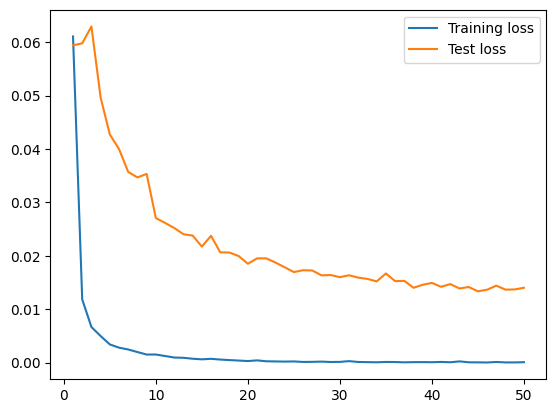

In [30]:
import matplotlib.pyplot as plt

x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [56]:
### Lets Do the prediction and check performance metrics
with torch.no_grad():
    train_predict=model(X_train)
    test_predict=model(X_test)


In [57]:
train_predict.shape

torch.Size([1542, 50, 1])

In [58]:
train_predict = train_predict.squeeze()
test_predict = test_predict.squeeze()


In [60]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [35]:
y_train.shape

torch.Size([1542, 50, 1])

In [36]:
train_predict.shape

(77100, 1)

In [63]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

t = scaler.inverse_transform(y_train.squeeze())

math.sqrt(mean_squared_error(t,train_predict))

24.4645595694855

In [97]:
t

array([[16881.86239417, 16849.22071686, 16823.66610742, ...,
        16227.74773442, 16198.10230392, 16294.52688071],
       [16849.22071686, 16823.66610742, 16843.02745644, ...,
        16198.10230392, 16294.52688071, 16240.44232164],
       [16823.66610742, 16843.02745644, 16853.28829956, ...,
        16294.52688071, 16240.44232164, 16120.3928679 ],
       ...,
       [18139.72217027, 18112.46388858, 18148.44509231, ...,
        18292.58600819, 18292.70046107, 18280.69681989],
       [18112.46388858, 18148.44509231, 18086.77885977, ...,
        18292.70046107, 18280.69681989, 18304.67390819],
       [18148.44509231, 18086.77885977, 18125.83068888, ...,
        18280.69681989, 18304.67390819, 18312.390625  ]])

In [96]:
train_predict

array([[16951.68110232, 16854.94921006, 16764.91534072, ...,
        16263.73842319, 16222.30632193, 16327.38900629],
       [16885.8104653 , 16885.85267375, 16829.29967112, ...,
        16222.30521534, 16327.3878997 , 16259.27389134],
       [16906.28267122, 16887.25282454, 16917.29512515, ...,
        16327.38805779, 16259.27341709, 16147.51982122],
       ...,
       [18038.94830493, 18142.11335023, 18180.24734311, ...,
        18289.30038845, 18282.29078178, 18264.96555585],
       [18147.54543575, 18165.93077359, 18116.96723008, ...,
        18282.28651351, 18264.96271034, 18194.62129714],
       [18115.51095943, 18102.36184093, 18139.77686736, ...,
        18264.9690337 , 18194.63236303, 18131.85211189]])

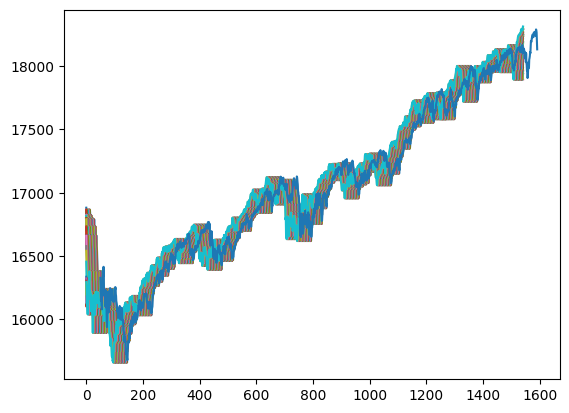

In [98]:
### Plotting
# shift train predictions for plotting
look_back=50
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict[:, -1].reshape(-1, 1)

# testPredictPlot = np.empty_like(df)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict[:, -1].reshape(-1, 1)


plt.plot(t)
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)


In [99]:
test_predict

array([[17732.50008179, 17795.09094819, 17887.99443899, ...,
        17508.92997259, 17578.59352121, 17669.9191747 ],
       [17820.83336153, 17883.59622341, 17867.57645591, ...,
        17578.46942519, 17669.76061635, 17639.49083274],
       [17870.58242489, 17755.99880763, 17596.42698749, ...,
        17669.64173712, 17639.39598228, 17756.50641565],
       ...,
       [17412.11089695, 17227.86215023, 17453.97646479, ...,
        17696.44679172, 17555.72128262, 17654.89881481],
       [17119.84550418, 17415.50385579, 17478.85890068, ...,
        17555.75037009, 17654.9267957 , 17559.25572672],
       [17505.68988107, 17531.35673021, 17515.46896292, ...,
        17654.59371252, 17558.95125676, 17715.4576683 ]])

In [102]:
tt = scaler.inverse_transform(y_test.squeeze())
tt.shape

(367, 30)

In [105]:
test_predict.shape

(367, 30)

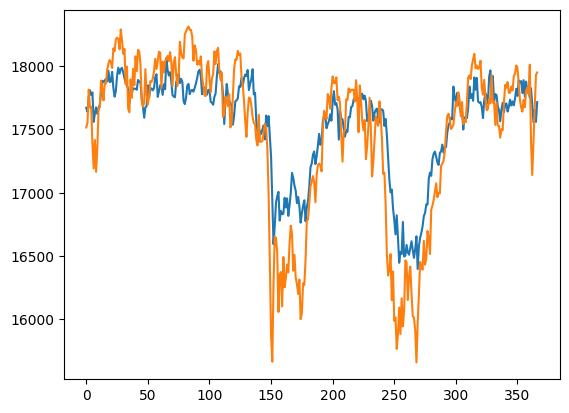

In [106]:
plt.plot(test_predict[:, -1])
plt.plot(tt[:, -1])
plt.show()

In [78]:
### Plotting
# shift train predictions for plotting
look_back=0
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict[:, -1])+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (1542,50) into shape (1542,1)

In [ ]:
import matplotlib.pyplot as plt

# Reshape the outputs and true values
train_predict = train_predict.reshape(-1, 1)
y_true = y_true.reshape(-1, 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red')
plt.title('Predicted vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
